# Measuring Political Preference with Sparse Text Classification Methods

Author: Jinna Sun

ID: 201812256


# Executive Summary



This report __aims__ to investigate different deep learning and machine learning methods to measure people's political preference given limited information. 

\\
__Data__ will not be a lengthy document but rather a short paragraph (i.e. a tweet text). Response will either be "Democratic" or "Republican". More than 200,000 tweets of US senators are scraped from Twitter for analysis, with each considered as an observation. Text vectorisation methods are applied as well as manual procedures to extract key information (e.g. number of capital letters, sentence length, etc.). 6 key factors are used together with more than 200 selected words to form a complex predictor base. 

\\
__In-depth analysis__ will begin with Convolutional Neural Networks (CNN), which is the core part of this report. Architecture designs are explored thoroughly including choice of convolutional layers, dense layers, dropout layers, normalisation, depth, width and activation function. Misclassification error rate on test data is calculated via the Validation Set Approach, which is later used to choose the optimal hyperparameters. Then the report will move on to Recurrent Neural Networks. A simple recurrent neural network is designed before the width parameters are selected optimally. Finally a Naive Bayes classifier, which is the most common algorithm used for text classification (Maron, 1961), is implemented for comparison. 

\\
It is __concluded__ that CNN consisting of 1 convolutional layer and 1 dense layer, with normalisation, small filters and width has the lowest test error rate of 28.5%. 

# Table of Contents

__0. Executive Summary__

__1. Introduction__

__2. Data Management__
* 2.1 Data Source
* 2.2 Text Preprocessing
* 2.3 Text Vectorization

__3. Convolutional Neural Networks__
* 3.1 Structure Overview
* 3.2 Minibatch Algorithm
* 3.3 Influence of Depth
* 3.4 Influence of Batch Normalisation
* 3.5 Influence of Activation Function
* 3.6 Influence of Hyper-Parameters
* 3.7 Train the Best CNN Model with More Data

__4. Recurrent Neural Networks__
* 4.1 Simple RNN
* 4.2 Influence of Width
* 4.3 Train the Best RNN Model with More Data

__5. Naive Bayes__

__6. Conclusion__

__7. Reference__

# 1.Introduction

This report aims to compare different text classification methods for the purpose of measuring people's political preference with sparse data. 

\\
Political preference does not always appear in absolute clarity for many voters. A lot of factors should be taken into account before casting a vote, including but not limited to candidates' policy proposals in economics, social, environment and national security. A vote, as a result of an integrated decision process, may require significant number of research and analysis. Deep learning and machine learning methods can serve to simplify this procedure by predicting a person's political preference based on characteristics of this person's politically related statements. A major challenge, however, is that data often come in the form of text files rather than simple numerical predictors. Number of predictors might be very huge while each observation is unlikely to contain most of the predictor words. In fact, most of the data entries are zero, leading to challenging sparsity. This report will dive deep into what methods have greater prediction accuracy. 

\\
We will start off by making __data choice__. We need to train the model on statements with a clear political leaning so that those "characteristics" explaining variability can be captured. We will scrape United States senators' recent 3000 tweets from Twitter with the response variable of interest being their political party: republican or democratic. A total of more than 200,000 tweets constitute our entire data set before randomly splitting it in train and test at 9:1 ratio. Cross Validation is not used for the sake of computing speed. That is, test and train set will remain still to the end. 

\\
Then we will move on to __selecting models__. This will be the core part of the report as in-depth analysis will be performed across Convolutional Neural Networks, Recurrent Neural Networks and Machine Learning algorithms. All models will use the same data set and same optimisation method so that comparison can be made. In this step we will run models until convergence of error rate. Mathematically it is ambigous whether converged test error rate is equivalent to converged training loss, though, still we tolerate this simplification for a faster algorithm. 

\\
At last, we will run more iterations on our __best model__ in order to reach the lowest test error rate in view of bias-variance trade-off. We will conclude our report by comparing these different methods and reporting the error rate of our best model. 

# 2.Data Management

## 2.1 Data Source

We need two sources of data for the purpose of this report:
* Senators' Twitter username and their corresponding political party: https://www.socialseer.com/resources/us-senator-twitter-accounts/ . Data from this website were firstly imported into a local Excel file before reading into a dataframe in Python.
* Each Senator's most recent 3000 tweets (if they have 3000). Data from Twitter are scraped using author's own developer credentials. 

__Critics__: While more than 200,000 tweets seem sufficient to train a model, most of the data entries are zero because number of predictors (words) is much higher than number of words in a typical tweet. This might cause a problem of overfitting. Another potential problem with this data set is that some senators may tweet more often than others. As a result, tweets may come from different parts on the time line and result in a bias. We therefore are assuming that recent years' politicians' word choices have not shifted significantly. Additionally we also assume that these senators' tweets are indeed about political issues rather than personal lives; and that 200,000 is sufficient to distinguish among models. Although not being done here, ideally we should choose election year's data to analyse. 

In [ ]:
#import all the packages needed for this report

import tweepy 
import pandas as pd
import re
import numpy as np
import os
from google.colab import files
import io

from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')
nltk.download('stopwords')  
from nltk.corpus import stopwords  

from sklearn.model_selection import train_test_split 
from sklearn.feature_extraction.text import TfidfVectorizer  
from sklearn.datasets import load_files  
from sklearn import model_selection, ensemble, preprocessing, linear_model, naive_bayes
import xgboost

import tensorflow as tf
import matplotlib.pyplot as plt
import time
from mpl_toolkits.mplot3d import Axes3D

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#read politicians' twitter username and political party from a local file
# uploaded = files.upload()
df = pd.read_csv('US Senators.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df.head(3)

,Official Twitter,Adjusted Name,Political Party
0,SenShelby,Richard Shelby,Republican
1,lisamurkowski,Lisa Murkowski,Republican
2,SenDanSullivan,Dan Sullivan,Republican


In [ ]:
#The following code creates a function to scrape data from Twitter.
#Twitter API information, note that this may not be shared with a third party 
#without author's consent.
consumer_key = "rUGPyMgFgniH0w3NbMv7Dv3Ff"
consumer_secret = "TSmomr1WYpK08NmrM1wnfIgIs1SpVePynuzlvnoGCIcUhd6Y8T"
access_key = "2711561539-fmZCmDbcNJJjW9AOVBoL21dOiTh5LDAROS0VIAw"
access_secret = "VgGc9nHfMQ9T70n4cLxu2rL6mnwI7EYtsoU6wOmmkezMn"


def tweet_scraper(user,party,total,speed):
    '''This function will scrape tweets given a username(user), total number of 
    tweets required(total) and the speed at which tweets are obtained(speed). 
    Note that user must be a string, total must be less than 3000 and speed must 
    be less than 200. It requires tweepy and pandas to run.'''

    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_key, access_secret)
    api = tweepy.API(auth)

    #initialise before while loop to scrape more
    all_tweets = []    
    new_tweets = api.user_timeline(screen_name = user,count=speed,
                                   tweet_mode="extended") #200 is the maximum speed
    all_tweets.extend(new_tweets)
    oldest = all_tweets[-1].id #store the latest tweet number

    while len(new_tweets) >= 0 and len(all_tweets) < total:
        new_tweets = api.user_timeline(screen_name = user,count=speed,
                                       tweet_mode="extended",max_id=oldest-1) 
        old_length = len(all_tweets)
        all_tweets.extend(new_tweets)
        new_length = len(all_tweets)
        oldest = all_tweets[-1].id
        if new_length-old_length==0: #break if all tweets have been downloaded
            break

    all_tweets = all_tweets[:total] #exactly 3000 tweets

    output={}
    output['Time'] = [tweet.created_at for tweet in all_tweets]
    output['Text'] = [tweet.full_text for tweet in all_tweets]
    output['Followers'] = [tweet.user.followers_count for tweet in all_tweets]
    output['Time'] = [tweet.created_at for tweet in all_tweets]
    output['Retweet'] = [tweet.retweet_count for tweet in all_tweets]
    output['Favourite'] = [tweet.favorite_count for tweet in all_tweets]
    output['Username'] = [user for tweet in all_tweets]
    output['Party'] = [party for tweet in all_tweets]

    output = pd.DataFrame(output)
    return(output) 

In [ ]:
#this code takes 10 minutes to run

mydt_1 = pd.DataFrame()
for row in range(int(df.shape[0]/2)):
    mydt_1 = mydt_1.append(tweet_scraper(df.iloc[row,0],df.iloc[row,2],3000,200))
    #print("Tweets downloaded for",df.iloc[row,0],"is 3000. ","Progress:",row/df.shape[0])

In [ ]:
#please wait for 15 minutes to run this second part again due to Twitter rate limits
#this code takes 10 minutes to run

mydt_2 = pd.DataFrame()
for row in range(int(df.shape[0]/2)+1,df.shape[0]):
    mydt_2 = mydt_2.append(tweet_scraper(df.iloc[row,0],df.iloc[row,2],3000,200))
    #print("Tweets downloaded for ",df.iloc[row,0],"is 3000. ","Progress:",row/df.shape[0])

In [ ]:
mydt = mydt_1.append(mydt_2)

In [ ]:
print(mydt.shape)
mydt.head(3)

(241898, 7)


,Time,Text,Followers,Retweet,Favourite,Username,Party
0,2019-04-21 13:22:59,Annette and I wish everyone a happy and blesse...,79791.0,4.0,52,SenShelby,Republican
1,2019-04-18 19:30:30,Great work happening at @UofAlabama National W...,79791.0,3.0,14,SenShelby,Republican
2,2019-04-18 17:47:47,I look forward to reviewing the Mueller report...,79791.0,17.0,75,SenShelby,Republican


In [ ]:
#remove retweets of others' tweets, only retain user's own tweets
mydt.index = np.arange(len(mydt))
mydt.drop(mydt[mydt['Favourite']==0].index,inplace=True)
mydt.drop(mydt[mydt['Party']==0].index,inplace=True)

#drop na
mydt.dropna(inplace=True)

#remove irrelevant columns
mydt.drop(labels=['Time','Followers','Retweet','Favourite'],axis=1,inplace=True)

#republican=1, democratic=0
mydt['Party'][mydt['Party']=='Republican'] = 1
mydt['Party'][mydt['Party']=='Democratic'] = 0

We have scraped 249818 tweets for analysis. After initial cleaning, 219765 of them remained. This cleansing includes these two actions:
* Remove na's.
* Some tweets are retweets of other user's tweet. We only want statements made by the user him/herself. These tweets typically have a 0 favourite count because all favourites go to the original tweeter. 
* Recode the response categories and remove irrelevant columns like retweet counts.

## 2.2 Text Preprocessing

Our predictors will be words, or more precisely real numbers mapped from each word. But some tweets contain URLs or special characters; some have punctuations or plural forms. Typical choice is to simply get rid of them with *"re"* package in python before moving on to vectorize the words. However, we take a different approach by adding them as predictors. We believe that "key predictors" of a tweet such as number of capital letters or hashtags could be very important in classifying whether someone is a republican or a democrat. Not only words themselves matter, their characteristics are also important. 

__6 Key Predictors__:

* $\text{Number of Hashtags}$
* $\text{Number of Capital Letters}$
* $\text{Number of URLs:}<=1$
* $\text{Tone}=\text{Number of "?"} + \text{Number of "!"}$
* $\text{Sentence Length}=\text{Number of words}$
* $\text{Average Word Length}=\frac{\sum_{i=1}^{\text{Sentence Length}} \text{Length of Word}_i}{\text{Sentence Length}}$


In [ ]:
#define a function to generate predictors for each tweet

def breakdown(sen):
    '''This function inputs a sentence and returns a dictionary with keys 
    being the variables of interest. Example: see test cases below'''
    
    output = {}

    #find URL first (at most 1 URL) and remove it from sentence
    start = sen.find('https:')
    output['URL'] = [int(start!=-1)]
    sen = re.sub(r'http\S+', '', sen) #remove URLs
    
    #find Hashtag, Tone and Cap
    output['Hashtag'] = [sen.count('#')]
    output['Tone'] = [sen.count('!')+sen.count('?')]
    output['Cap'] = [sum(1 for i in sen if i.isupper())]
    
    #find Len_S
    words = re.sub("[^\w]", " ",  sen).split()
    output['Len_S'] = [len(words)]
    
    #find Len_W
    words = [len(i) for i in words]
    output['Len_W'] = [sum(words)/max(len(words),1)]
    
    return pd.DataFrame(output,index=['Count'])

#test cases
print('Test Case I:\n\"Hello, world! #python"\n',breakdown('Hello, world! #python'))
print('Test Case II:\n\"the failing NYTimes!! #FAKENEWS https://t.co/JAzSE6yEes"\n',
      breakdown('the failing NYTimes!! #FAKENEWS https://t.co/JAzSE6yEes'))

Test Case I:
"Hello, world! #python"
        URL  Hashtag  Tone  Cap  Len_S     Len_W
Count    0        1     1    1      3  5.333333
Test Case II:
"the failing NYTimes!! #FAKENEWS https://t.co/JAzSE6yEes"
        URL  Hashtag  Tone  Cap  Len_S  Len_W
Count    1        1     2   11      4   6.25


In [ ]:
#this code takes around 10 minutes to run
#preprocess text contents

tweets = [] #store cleaned text
key_predictors = pd.DataFrame() #store key predictors defined above
stemmer = WordNetLemmatizer() #change plural forms into single form

for row in range(mydt.shape[0]):  
  #calculate key predictors and remove URLs
  key_predictors = key_predictors.append(breakdown(mydt.iloc[row,0])) 
  
  #remove special characters
  new_text = re.sub(r'\W', ' ', mydt.iloc[row,0])

  #replace single characters by a space
  new_text = re.sub(r'\s+[a-zA-Z]\s+', ' ', new_text)

  #replace single characters from the start by a space
  new_text = re.sub(r'\^[a-zA-Z]\s+', ' ', new_text) 

  #replace multiple spaces with single space
  new_text = re.sub(r'\s+', ' ', new_text, flags=re.I)

  #converting to lowercase
  new_text = new_text.lower()

  #lemmatization: change plural forms into single form
  new_text = new_text.split()
  new_text = [stemmer.lemmatize(word) for word in new_text]
  new_text = ' '.join(new_text)

  tweets.append(new_text)
  if row%(mydt.shape[0]/5)==0: print("Progress:",row/mydt.shape[0])

Progress: 0.0
Progress: 0.2
Progress: 0.4
Progress: 0.6
Progress: 0.8


In [ ]:
key_predictors.index = np.arange(key_predictors.shape[0])
print(mydt.iloc[0,0])
print(tweets[0])
print(key_predictors.head(3))

Annette and I wish everyone a happy and blessed Easter. Hope you enjoy it with friends and family. He is risen! #EasterSunday
annette and wish everyone happy and blessed easter hope you enjoy it with friend and family he is risen eastersunday
   URL  Hashtag  Tone  Cap  Len_S     Len_W
0    0        1     1    7     22  4.545455
1    1        1     0   11     43  4.744186
2    0        0     0    8     43  5.372093


In [ ]:
key_predictors.shape

(219765, 6)

## 2.3 Text Vectorisation

While tensorflow has an elegant way of creating an embedding layer to vectorise texts, here we create this funciton mapping manually so that different deep learning and machine learning models (which use the same data) can be compared. 

A modification of "__Bag of Words__" model is used to convert tweet text into real numbers. Briefly "Bag of Words" model is used to count the number of appearances of each word in each text, before mapping this word to an integer related to its frequency. An apparent shortcoming of this typical langauge processing method is that it gives higher weights to longer texts than shorter ones, and that it does not consider this word's frequency in other texts. To overcome this drawback, we use an adjusted method called "TF-IDF", i.e. Term Frequency times Inverse Dcument Fequency where the calculations are performed as below:  

$\text{Term Frequency (TF)} = \frac{\text{Frequency of a word}}{\text{Total words in the tweet}}$   

$\text{Inverse Document Frequency (IDF)} = \frac{log(\text{Total number of tweets})}{\text{Number of tweets containing the word}}$  

$TF\text{-}IDF(word)=TF(word)\times IDF(word)$  

By this structure, a particular word will have a higher mapped real number if it appears more frequently in one particular tweet than all other tweet texts. It is also worth noting that we do not want words (predictors) that are heavily used by all senators/both parties, neither do we want a word to be used by one senator/party only. These two kinds of predictors will reduce our model's interpretability. Therefore, we set some boundary conditions before mapping a word into real space:  
* Only words contained by at least 1% of the tweets will be used. 
* Only words contained by less than 70% of the tweets will be used.

In [ ]:
#hyperparameters
min_df=0.01
max_df=0.7

#text vectorization
def text_map(document,min_df=min_df,max_df=max_df):
  '''This function inputs a list of strings, and outputs a dataframe with rows 
  being each string, cols being words, and entries being vectorised number.'''

  tfidfconverter = TfidfVectorizer(min_df=min_df, 
    max_df=max_df, stop_words=stopwords.words('english'))
  return(pd.DataFrame(tfidfconverter.fit_transform(document).toarray()))

#generate predictors and response data
vectorised_words = text_map(tweets)
X = pd.concat([key_predictors,vectorised_words],axis=1,
       join='outer',sort=False,ignore_index =True) #first 6 cols: key predictors
Y = mydt.iloc[:,2]

#randomly split the data into train and test
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.1,shuffle=True)
print("Train X has shape",X_train.shape)
print("Test X has shape",X_test.shape)
print("Train Y has shape",Y_train.shape)
print("Test Y has shape",Y_test.shape)

Train X has shape (197788, 237)
Test X has shape (21977, 237)
Train Y has shape (197788,)
Test Y has shape (21977,)


In [ ]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,227,228,229,230,231,232,233,234,235,236
112515,0,1,0,10,23,4.913043,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
8602,1,0,0,11,11,5.363636,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.494655
160383,0,1,0,7,42,5.095238,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
191619,0,0,1,3,17,5.117647,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
187444,0,0,0,7,28,3.857143,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


219765 observations were randomly split in 1:9 as test and train set. Number of predictors in total are 237. Among them the leftmost 6 predictors are "key predictors" defined in earlier sections, while the rest 231 are vectorised words. 

We have mentioned before that words that appear in less than 1% of these observations are not selected in avoidance of distortion of model. Still, a quick peak into this dataframe suggests that most of the entries are still zero. This is inevitable because a single tweet typically contains much fewer words than number of predictors. Based on this observation, we would expect __models with greater sparsity__ (ability to select predictors) to work better in the sense that they approximate linear system solutions with greater prediction accuracy and computational efficiency. Similarly, neural networks that aggregate information might also be desirable. 

# 3.Convolutional Neural Networks

## 3.1 Structure Overview

In this overview we look at each layer's potential benefits. After specifying some hyperparameters inside each layer, a CNN model is created via a function with the following layers passed on as arguments. 

__Layer Choices__:

* __Number of Convolutional Layers__: number of times to include convolutional layers in the neural network. (N_conv)
* __Max Pooling Layers__: aggregate information based on maximum criterion to be included after a convolutional layer.
* __Number of Dense Layers__: number of transformations of the data before output. (N_dense)
* __Dropout Layers__: randomly drop information in the training data which reduces overfitting. 
* __Normalisation__: normalise previous layer's outputs to reduce covariation which improves optimising efficiency.

Our typical convolutional neural network structure is shown below, while the depth is yet to be investigated. We will pass these choices as arguments when we define our CNN function.  
$[\text{Convolutional}\rightarrow \text{Pooling}\rightarrow \text{Dropout}\rightarrow \text{Normalisation}]\times \text{N_conv}\rightarrow [\text{Dense}\rightarrow \text{Dropout}\rightarrow \text{Normalisation}]\times \text{N_dense}$

\\
__Initial Parameter Choices__:

While pooling layers' parameters are arbitrarily chosen as size 2 with strides 2, we want to be more careful with convolutional and dense layers. Filters and units are set at 32 and 256 initially. In a later section we will explore the influence of different hyperparameters on error rate. 

Each time an additional convolutional layer is added, we double filters and decrease kernel size by 1. Generally speaking, we want the convolutional layer to aggregate information aggressively at first because raw data contain much irrelevant information. But as the neural network goes deeper, we prefer more careful and detailed convolution process to capture more data features. This is represented by __increasing filters and decreasing kernel size__. Similar logic applies to dense layers as well. Each additional dense layer will double the units, or fully connected neurons before output. 

Dropout rate is arbitrarily chosen at 30% and activation function is set to be rectified linear unit (__relu__) except for the very last step. Output layer is a dense layer mapping each observation into a vector of 2, which represents the likelihood of belonging to each class. We believe __sigmoid__ function would be a better choice in this last step before output. 

In [ ]:
#convolutional layer hyperparameters
filters = 32
kernel_size = 5
padding = 'same'
conv_strides = 1
activation = tf.nn.relu

#pooling layer hyperparameters
pool_size = 2
pool_strides = 2

#dropout layer hyperparameters
rate = 0.3

#dense layer hyperparameters
units = 256

In [ ]:
#This chunk creates different cnn models. 

def cnn(data,n_conv,n_dense,pooling,dropout,normalise,activation=activation):
  '''This function inputs train data , all the convolutional neural network 
  parameters and outputs a vector of length 2 representing the likelihood 
  of belonging to each class.'''
  
  with tf.variable_scope('cnn', reuse=tf.AUTO_REUSE):
    temp = tf.reshape(data, [-1,X_train.shape[1],1])
    
    #loop through convolutional layers
    conv = 0
    while conv < n_conv:
      #convolutional
      temp = tf.layers.conv1d(inputs=temp,filters=filters*(2**conv),
                              kernel_size=kernel_size-conv,padding=padding,
                              strides=conv_strides,activation=activation)
      #pooling
      if pooling: temp = tf.layers.max_pooling1d(inputs=temp,
                               pool_size=pool_size,strides=pool_strides)
      #dropout
      temp = tf.layers.dropout(inputs=temp,rate=rate,training=dropout)
      #normalisation
      if normalise: temp = tf.layers.batch_normalization(temp)
      conv += 1
      
    temp = tf.reshape(temp, [-1,temp.shape[1].value*temp.shape[2].value])  
    
    #loop through dense layers
    dense = 0
    while dense < n_dense:
      #dense
      temp = tf.layers.dense(inputs=temp,units=units*(2**dense),
                             activation=activation)
      #dropout
      temp = tf.layers.dropout(inputs=temp,rate=rate,training=dropout)
      #normalisation
      if normalise: temp = tf.layers.batch_normalization(temp)
      dense += 1
      
    outputs = tf.layers.dense(inputs=temp,units=2,activation=tf.sigmoid) #vector of 2

  return outputs

## 3.2 Minibatch Algorithm

A minibatch algorithm is implemented to improve efficiency. Train set is randomly shuffled in each epoch before running the optimiser with many batches. Optimiser is selected to be "Adam" with decaying learning rate for each epoch. Number of batches is set at 100 with batch size being 128. There are 197788 rows in the train data. It is thus ideal to run $\frac{197788}{128\times 100}=15$ epochs to be reasonably sufficient. 

For some deep neural networks, however, even 15 epochs can be very time-consuming and more importantly, unnecessary. Hence we will add two stopping criteria to force the algorithm to quit should the scenario occur:
* Stop if absolute change in error rate is less than 0.005 for consecutive 4 epochs. We consider the loss to be converged in this scenario.
* Stop if running times have exceeded 3 minutes. We do not possess a super GPU or TPU to run every network structure there is efficiently. If our model runs over 3 minutes on this 200,000-sized train set without convergence, imagine the length of time it would take in practice where we need to train the model on much more observations. Hence we will deem the model inefficient should this scenario happen.

Once we have selected our best model, we will relax these stopping criteria to have better performances. 


In [ ]:
#minibatch hyperparameters
n_epoch = 15
n_batches = 100
batch_size = 128
converge_change = 0.005
time_stop = 60*3

In [ ]:
def minibatch(cnn, n_conv, n_dense, pooling, dropout, normalise,
              n_epoch=n_epoch, n_batches=n_batches, batch_size=batch_size, 
              activation=activation, printing=True):
  '''This function inputs a CNN as a predefined funciton with all arguments 
  passed on and outputs error rate.'''
  
  start = time.time()
  tf.reset_default_graph()
  with tf.variable_scope('cnn',reuse=tf.AUTO_REUSE):
  
    #create placeholder for data
    data_x = tf.placeholder(tf.float32, shape=(batch_size,X_train.shape[1]))
    data_y = tf.placeholder(tf.int32, shape=(batch_size, ))
    y_label = tf.one_hot(data_y,depth=2) 
    lr = tf.placeholder(tf.float32) #learning rate

    #model settings
    y_hat = cnn(data_x,n_conv, n_dense, pooling, dropout, normalise, activation=activation)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_label,logits=y_hat))
    optimiser = tf.train.AdamOptimizer(lr).minimize(loss)

    #predictions
    preds = cnn(X_test.astype('float32'),n_conv, n_dense, pooling, dropout, normalise, activation=activation)
    predictions = tf.nn.softmax(preds)
    predictions_idx = tf.argmax(predictions, axis=1)

    #initiate variables
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())

    #looping through epochs
    top1_error_rate = []
    for epoch in range(n_epoch):
      if printing and epoch%(n_epoch/5)==0: print('Progress so far:',epoch/n_epoch) 
      learning_rate = 0.001/np.sqrt(epoch+1)
      ID = np.random.permutation(np.arange(X_train.shape[0]))
      shuffled_x = X_train.iloc[ID,:]  
      shuffled_y = Y_train.iloc[ID,]  

      #looping through batches
      error_list = []
      for n in range(n_batches):  
        batch_x = shuffled_x[n * batch_size:(n + 1) * batch_size]
        batch_y = shuffled_y[n * batch_size:(n + 1) * batch_size]
        _, p = sess.run([optimiser, predictions_idx], feed_dict={data_x:batch_x,data_y:batch_y,lr:learning_rate})
        #count number of errors after training each batch
        error_list.append(np.mean(np.array(p)!=np.array(Y_test)))
        
      top1_error_rate.append(np.mean(error_list))
      
      #stop if converged
      if epoch>=5:
        recent = np.diff(top1_error_rate[epoch-5:epoch])
        recent = [abs(i)<converge_change for i in recent]
        if all(recent):
          print('Converged after epoch:',epoch)
          break
          
      #stop if inefficient
      if time.time()-start>time_stop:
        print('Running time exceeded time limit, Forced to stop. ')
        break
      

  if printing: print('Running time:',time.time()-start,'seconds')
  return(top1_error_rate)

## 3.3 Influence of Depth

Deeper networks increase the model's flexibility at a cost of its accuracy. This is similar to the bias-variance trade-off in machine learning terms. Deeper networks tend to explore the train set more (with a low train error rate) but end up in worse-off test error rates. For this reason, we will take remedial measures to prevent the network from overfitting. 2 convolutional layers or more will come with a maximum pooling layer right after it to lose some information. 3 convolutional layers will additionally add a dropout layer to reduce burden. Same dropout structure applies for dense layer depth as well. To test the impact of convolutional and dense layers, we use these 9 different neural networks:  

__1 Dense Layer__  
$CNN_1=[Convolutional]\times 1\rightarrow [Dense]\times 1$  
$CNN_2=[Convolutional+ Pooling]\times 2\rightarrow  [Dense]\times 1$  
$CNN_3=[Convolutional+ Pooling+ Dropout]\times 3\rightarrow [Dense+ Dropout]\times 1$  

__2 Dense Layers__  
$CNN_4=[Convolutional]\times 1\rightarrow [Dense]\times 2$  
$CNN_5=[Convolutional+ Pooling]\times 2\rightarrow [Dense]\times 2$  
$CNN_6=[Convolutional+ Pooling+ Dropout]\times 3\rightarrow [Dense+ Dropout]\times 2$  

__3 Dense Layers__  
$CNN_7=[Convolutional]\times 1\rightarrow [Dense]\times 3$  
$CNN_8=[Convolutional+ Pooling]\times 2\rightarrow [Dense]\times 3$  
$CNN_9=[Convolutional+ Pooling+ Dropout]\times 3\rightarrow [Dense+ Dropout]\times 3$  

In [ ]:
error1 = minibatch(cnn,n_conv=1, n_dense=1, pooling=False, dropout=False, normalise=False)
error2 = minibatch(cnn,n_conv=2, n_dense=1, pooling=True, dropout=False, normalise=False)
error3 = minibatch(cnn,n_conv=3, n_dense=1, pooling=True, dropout=True, normalise=False)
error4 = minibatch(cnn,n_conv=1, n_dense=2, pooling=False, dropout=False, normalise=False)
error5 = minibatch(cnn,n_conv=2, n_dense=2, pooling=True, dropout=False, normalise=False)
error6 = minibatch(cnn,n_conv=3, n_dense=2, pooling=True, dropout=True, normalise=False)
error7 = minibatch(cnn,n_conv=1, n_dense=3, pooling=False, dropout=False, normalise=False)
error8 = minibatch(cnn,n_conv=2, n_dense=3, pooling=True, dropout=False, normalise=False)
error9 = minibatch(cnn,n_conv=3, n_dense=3, pooling=True, dropout=True, normalise=False)

Progress so far: 0.0
Progress so far: 0.2
Converged after epoch: 7
Running time: 41.295252084732056 seconds
Progress so far: 0.0
Progress so far: 0.2
Progress so far: 0.4
Converged after epoch: 9
Running time: 106.34943652153015 seconds
Progress so far: 0.0
Progress so far: 0.2
Converged after epoch: 7
Running time: 165.95756220817566 seconds
Progress so far: 0.0
Progress so far: 0.2
Converged after epoch: 7
Running time: 42.24881196022034 seconds
Progress so far: 0.0
Progress so far: 0.2
Progress so far: 0.4
Converged after epoch: 8
Running time: 97.98082971572876 seconds
Progress so far: 0.0
Progress so far: 0.2
Progress so far: 0.4
Converged after epoch: 8
Running time: 190.3173370361328 seconds
Progress so far: 0.0
Progress so far: 0.2
Converged after epoch: 6
Running time: 42.37488913536072 seconds
Progress so far: 0.0
Progress so far: 0.2
Progress so far: 0.4
Converged after epoch: 9
Running time: 116.34682703018188 seconds
Progress so far: 0.0
Progress so far: 0.2
Progress so fa

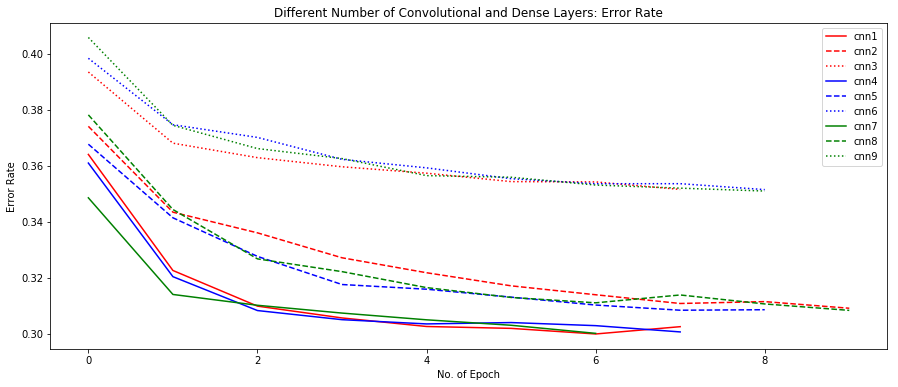

In [ ]:
#influence of depth
plt.figure(figsize=(15,6))
plt.plot(error1,color='red');plt.plot(error2,linestyle='--',color='red');plt.plot(error3,linestyle=':',color='red')
plt.plot(error4,color='blue');plt.plot(error5,linestyle='--',color='blue');plt.plot(error6,linestyle=':',color='blue')
plt.plot(error7,color='green');plt.plot(error8,linestyle='--',color='green');plt.plot(error9,linestyle=':',color='green')
plt.ylabel("Error Rate")
plt.xlabel("No. of Epoch")
plt.title("Different Number of Convolutional and Dense Layers: Error Rate")
plt.legend(['cnn'+str(i) for i in range(1,10)])

__Discussion of Graph__:  
* The graph above shows differences between neural networks with different depth. Note that lines with the __same colour__ have the same number of dense layers, while lines with the __same line type__ have the same number of convolutional layers. Our algorithm is designed to stop after convergence has been reached, hence not all lines have the same length. 
* We can conclude that __the fewer convolutional layers there are, the better prediction accuracy will be__. It can be observed that cnn1, cnn4 and cnn7 significantly outperform the rest with a lower misclassification error rate. They all have 1 convolutional layer. Among them cnn7 with the most dense layers has the best performance. Only 1 convolutional layer is needed. 
* __To what extent is this conclusion valid?__ It appears that for this data set, additional convolutional layers, even with pooling and dropout, tend to make unnecessary transformations and overfit the training data. The negative impact on prediction accuracy might even be increasing at an increasing rate. This might arise from the potential fact that there is just not much "characteristics" in the data for us to capture, which is reasonable if you think about how sparse our training set is. Or this might be a consequence of too aggressive pooling and dropouts resulting in under-fitting. If we decrease the pooling size and strides, or decrease the dropout rate, we might end up with some different results.

__More Dense Layers__:  
Notice that for CNN9 with 3 dense layers, the algorithm fails to converge and is forced to stop when the time exceeds 3 min. Logically speaking, this model might converge to some lower error rates if we let it. Sometimes more dense layers can indeed have improvements in prediciton accuracy. But they heavily increase running time. The following analysis verifies this point and investigates in detail about this accuracy-efficiency trade off.  
$CNN_{10}=[Convolutional]\times 1\rightarrow [Dense]\times 4$  
$CNN_{11}=[Convolutional]\times 1\rightarrow [Dense]\times 5$  
$CNN_{12}=[Convolutional]\times 1\rightarrow [Dense]\times 6$  
$CNN_{13}=[Convolutional]\times 1\rightarrow [Dense]\times 7$  

In [ ]:
error10 = minibatch(cnn,n_conv=1, n_dense=4, pooling=False, dropout=False, normalise=False)
error11 = minibatch(cnn,n_conv=1, n_dense=5, pooling=False, dropout=False, normalise=False)
error12 = minibatch(cnn,n_conv=1, n_dense=6, pooling=False, dropout=False, normalise=False)
error13 = minibatch(cnn,n_conv=1, n_dense=7, pooling=False, dropout=False, normalise=False)

Progress so far: 0.0
Progress so far: 0.2
Converged after epoch: 7
Running time: 71.0642499923706 seconds
Progress so far: 0.0
Progress so far: 0.2
Progress so far: 0.4
Converged after epoch: 8
Running time: 162.8536605834961 seconds
Progress so far: 0.0
Running time exceeded 3 min limit, Forced to stop. 
Running time: 227.03927540779114 seconds
Progress so far: 0.0
Running time exceeded 3 min limit, Forced to stop. 
Running time: 205.86750316619873 seconds


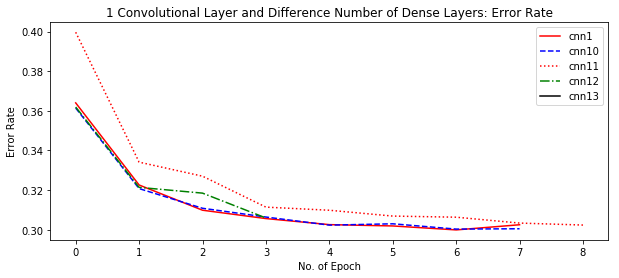

In [ ]:
#influence of number of dense layers
plt.figure(figsize=(10,4))
plt.plot(error1,color='red')
plt.plot(error10,linestyle='--',color='blue')
plt.plot(error11,linestyle=':',color='red')
plt.plot(error12,linestyle='-.',color='green')
plt.plot(error13,linestyle='-',color='black')

plt.ylabel("Error Rate")
plt.xlabel("No. of Epoch")
plt.title("1 Convolutional Layer and Difference Number of Dense Layers: Error Rate")
plt.legend(['cnn1','cnn10','cnn11','cnn12','cnn13'])

Each addtional dense layer increases the running time at an exponential rate with little or no improvement in prediction accuracy. It is thus unnecessary to add more than 1 dense layers. We conclude that our best model so far is:

$CNN_1=[Convolutional]\times 1\rightarrow [Dense]\times 1$  

## 3.4 Influence of Batch Normalisation

Normalisation might sometimes reduce covariation in the data set and potentially have better fit. This is especially the case when data values vary a lot in absolute terms which distorts the coefficient. But for our data most of the values remain between 0 and 100. We do not expect normalisation to be very helpful considering this extra step might also increase run time. We compare our so-far best model $CNN_1$ with an additional normalised procedure after both convolutional and dense layer. There has been empirical evidence how dropout layers should be used together with normalisation __(Li, Chen 2018)__. Hence we test it with an additional dropout layer as well. 

$CNN_{14}=[Convolutional\rightarrow Normalise]\times 1\rightarrow [Dense\rightarrow Normalise]\times 1$  

$CNN_{15}=[Convolutional\rightarrow Dropout\rightarrow Normalise]\times 1\rightarrow [Dense\rightarrow Dropout\rightarrow Normalise]\times 1$  


In [ ]:
error14 = minibatch(cnn,n_conv=1, n_dense=1, pooling=False, dropout=False, normalise=True)
error15 = minibatch(cnn,n_conv=1, n_dense=1, pooling=False, dropout=True, normalise=True)

Progress so far: 0.0
Progress so far: 0.2
Progress so far: 0.4
Converged after epoch: 7
Running time: 51.36625909805298 seconds
Progress so far: 0.0
Progress so far: 0.2
Progress so far: 0.4
Converged after epoch: 8
Running time: 79.92769622802734 seconds


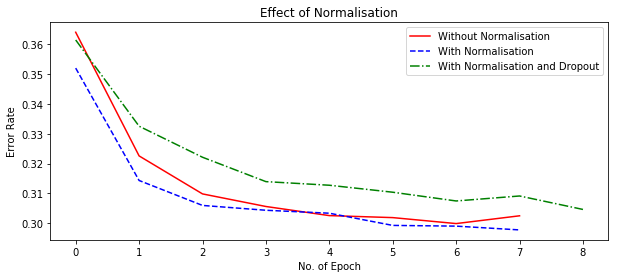

In [ ]:
#influence of batch normalisation
plt.figure(figsize=(10,4))
plt.plot(error1,color='red')
plt.plot(error14,linestyle='--',color='blue')
plt.plot(error15,linestyle='-.',color='green')

plt.ylabel("Error Rate")
plt.xlabel("No. of Epoch")
plt.title("Effect of Normalisation")
plt.legend(['Without Normalisation','With Normalisation',
            'With Normalisation and Dropout'])

Contrary to our expectation, it can be observed that batch normalisation might actually increase the performance slightly, although it is very arguable due to minibatch's algorithm's stochastic nature. Run time is not increased by a lot, only 10 seconds. Dropout layers used together with batch normalisation is definitely not helping. We hence conclude that our best model so far is:

$CNN_{14}=[Convolutional\rightarrow Normalise]\times 1\rightarrow [Dense\rightarrow Normalise]\times 1$  

## 3.5 Influence of Activation Function

Activation funciton can have significant impact on our data set. But there is no universal rule on which activation funciton will have the best quality. For previous neural networks, we used a rectified linear function. Now we test two additional activation functions: linear and tangent hyperbolic. 

$CNN_{16}=[Convolutional\rightarrow Normalise]\times 1\rightarrow [Dense\rightarrow Normalise]\times 1 \text{   with Linear Activation}$  

$CNN_{17}=[Convolutional\rightarrow Normalise]\times 1\rightarrow [Dense\rightarrow Normalise]\times 1 \text{   with Tangent Hyperbolic Activation}$  



In [ ]:
error16 = minibatch(cnn,n_conv=1, n_dense=1, pooling=False, dropout=False, normalise=True, activation=None)
error17 = minibatch(cnn,n_conv=1, n_dense=1, pooling=False, dropout=False, normalise=True, activation=tf.nn.tanh)

Progress so far: 0.0
Progress so far: 0.2
Progress so far: 0.4
Progress so far: 0.6
Progress so far: 0.8
Running time: 85.7122483253479 seconds
Progress so far: 0.0
Progress so far: 0.2
Progress so far: 0.4
Converged after epoch: 7
Running time: 52.317174673080444 seconds


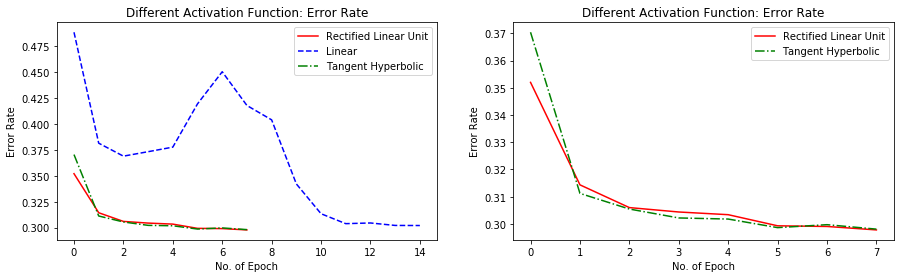

In [ ]:
#influence of activation function
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot(error14,color='red')
plt.plot(error16,linestyle='--',color='blue')
plt.plot(error17,linestyle='-.',color='green')
plt.ylabel("Error Rate")
plt.xlabel("No. of Epoch")
plt.title("Different Activation Function: Error Rate")
plt.legend(['Rectified Linear Unit','Linear','Tangent Hyperbolic'])

plt.subplot(1,2,2)
plt.plot(error14,color='red')
plt.plot(error17,linestyle='-.',color='green')
plt.ylabel("Error Rate")
plt.xlabel("No. of Epoch")
plt.title("Different Activation Function: Error Rate")
plt.legend(['Rectified Linear Unit','Tangent Hyperbolic'])

The stopping criterion of convergence causes these three lines to have different lengths. But we can still tell how tangent hyperbolic tends to have lower error rates in almost every epoch. Research __(Karlik,B 2011)__ has suggested similar result. We hence conclude that our so-far best model is: 

$CNN_{17}=[Convolutional\rightarrow Normalise]\times 1\rightarrow [Dense\rightarrow Normalise]\times 1 \text{   with Tangent Hyperbolic Activation}$  

## 3.6 Influence of Hyper-Parameters

Now that we have chosen the best structure of this neural network, we can investigate further on how hyperparameters can affect prediction accuracy. Key parameters influencing convolutional and dense layers are __filter__ and __units__ respectively. While there are other parameters such as kernel size or padding, we do not investigate them in this report. For kernel size, we mentioned earlier (intuitively) how a decreasing kernel size with deeper layers can have potential benefits. On the other hand, for padding choices which mainly affect edges of the data, the difference is believed to be insignificant considering the 1 dimension data we have. 



In [ ]:
#reset stopping time limit to run faster
time_stop = 60 #1 minute

In [ ]:
#This code takes an hour to run.
filter_space = [16,32,64,128]
unit_space = [16,32,64,128,256,512,1024,2048]
param = np.zeros([len(filter_space),len(unit_space)])

for i,filters_ in enumerate(filter_space):
  for j,units_ in enumerate(unit_space):
    print('Total Progress:',(i*len(filter_space)+j)/len(unit_space)**2)
    
    #reset parameters
    filters = filters_
    units = units_
    param[i,j] = minibatch(cnn,n_conv=1, n_dense=1, pooling=False,dropout=False,
                       normalise=True, activation=tf.nn.tanh,printing=False)[-1]

In [ ]:
param

array([[0.3076985 , 0.30914138, 0.30962734, 0.31032534, 0.30854985,
        0.31032989, 0.30954543, 0.31219548],
       [0.3079838 , 0.30832825, 0.30928653, 0.30924648, 0.31101606,
        0.30985894, 0.44810666, 0.31475907],
       [0.31013423, 0.31054512, 0.31104154, 0.31008054, 0.31036356,
        0.31485599, 0.49219684, 0.48677982],
       [0.31321245, 0.31286754, 0.31397279, 0.31453929, 0.31583019,
        0.33413887, 0.49074032, 0.50839878]])

Text(0.5, 0, 'Error Rate after 6 Epochs')

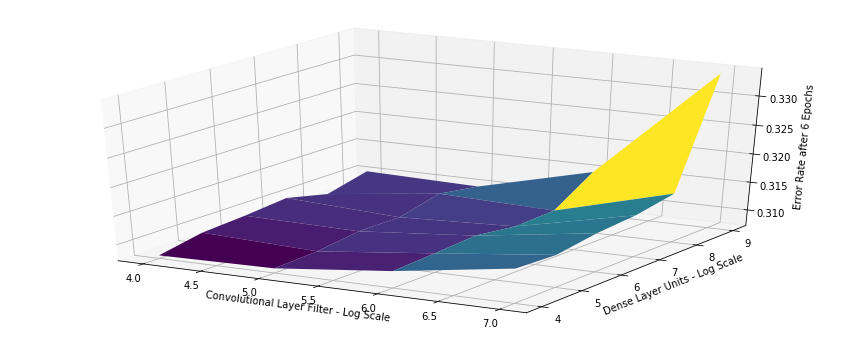

In [ ]:
#influence of hyperparameters
filter_space = [16,32,64,128]
unit_space = [16,32,64,128,256,512,1024,2048]
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111, projection='3d')
x = [np.log(i)/np.log(2) for i in filter_space]
y = [np.log(i)/np.log(2) for i in unit_space[:-2]] #trim unconverged models
X, Y = np.meshgrid(x, y)
Z = param[:,:-2].transpose()
ax.plot_surface(X,Y,Z,cmap='viridis')
ax.set_xlabel('Convolutional Layer Filter - Log Scale')
ax.set_ylabel('Dense Layer Units - Log Scale')
ax.set_zlabel('Error Rate after 6 Epochs')

In [ ]:
print("The best CNN Model is the one with row %s and col %s"
      % np.where(param==np.min(param)))

The best CNN Model is the one with row [0] and col [0]


Now we can conclude that the best CNN is:

$$CNN_{best}=[Convolutional\rightarrow Normalise]\times 1\rightarrow [Dense\rightarrow Normalise]\times 1 \\ \text{   with Tangent Hyperbolic Activation, Convolutional Filter=16,Dense Units=16}$$

## 3.7 Train the best CNN Model with More Data

Now let's train this best model on more batches and epochs to achieve best performance. 

In [ ]:
#This code chunk takes about 1 hour to run
#reset all parameters to be the optimal ones

#convolutional layer hyperparameters
filters = 16
kernel_size = 5
padding = 'same'
conv_strides = 1
activation = tf.nn.tanh

#dense layer hyperparameters
units = 16

#minibatch hyperparameters
n_epoch = 50
n_batches = int(X_train.shape[0]/128)
batch_size = 128
converge_change = 0 #remove convergence criterion
time_stop = 10000000 #do not stop until finished

error_best = minibatch(cnn,n_conv=1, n_dense=1, pooling=False,dropout=False,
                       normalise=True, activation=tf.nn.tanh,printing=True,
                      n_epoch=n_epoch, n_batches=n_batches, batch_size=batch_size)

Progress so far: 0.0
Progress so far: 0.2
Progress so far: 0.4
Progress so far: 0.6
Progress so far: 0.8
Running time: 2060.4775202274323 seconds


Text(0.5, 0, 'No. of Epochs')

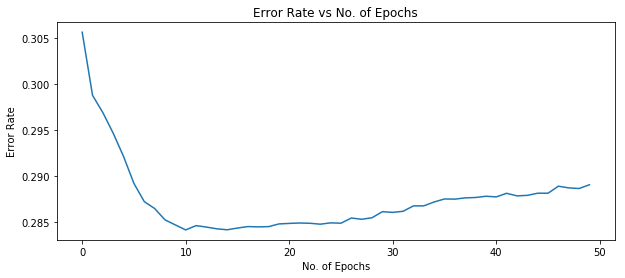

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(error_best)
plt.title("Error Rate vs No. of Epochs")
plt.ylabel("Error Rate")
plt.xlabel("No. of Epochs")

This is a beautiful graph showing the trade-off between bias and variance. As we run more epochs, model becomes more fit to the train set and resulting in overfitting after approximately the 10th epoch. Although train error rate will be lower and lower as we train more data, test error will actually rise. Our model does not learn the data any more but rather just memorise the data. Hence the optimal number of epochs should be 10. And our best model $$CNN_{best}=[Convolutional\rightarrow Normalise]\times 1\rightarrow [Dense\rightarrow Normalise]\times 1 \\ \text{   with Tangent Hyperbolic Activation, Convolutional Filter=16, Dense Units=16}$$ reported an error rate of $28.5\text{%}$ at epoch 10. 

# 4.Recurrent Neural Networks

## 4.1 Simple RNN

We use tensorflow.keras to run the model. Every setting is the same as CNN except now we use a binary cross entropy loss instead of a softmax cross entropy loss with logits. They do not differ much in nature. Optimiser is still Adam. But now we will run through all data in each epoch instead of only 100 batches. We will run for 5 epochs to select the best model before comparing with the best CNN model with 15 epochs (the same parameter setting with section 3.7)

In [ ]:
#hyper parameters
units = 512
activation = tf.nn.tanh
batch_size = 128
n_epoch = 5

In [ ]:
def rnn(units,n_epoch=n_epoch,printing=True):
  '''This function inputs number of units or widths in the simple RNN layer
  and outputs error rate of the last epoch.. '''
  
  with tf.Graph().as_default():
    model = tf.keras.Sequential()
    tf.keras.layers.SimpleRNN(units=units,activation=activation)
    model.add(tf.keras.layers.Dense(2, activation=tf.nn.relu))

  with tf.Session(graph=tf.Graph()) as sess:
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
    history = model.fit(np.array(X_train), np.array(Y_train), batch_size=batch_size, 
                        epochs=n_epoch,verbose=printing)
    results = model.evaluate(X_test, Y_test)
    
  return 1-results[1] #error=1-accuracy

In [ ]:
rnn(units=units)

Epoch 1/5
197788/197788 [==============================] - 6s 30us/sample - loss: 1.8242 - acc: 0.5692
Epoch 2/5
197788/197788 [==============================] - 6s 29us/sample - loss: 1.7288 - acc: 0.6155
Epoch 3/5
197788/197788 [==============================] - 6s 29us/sample - loss: 0.6415 - acc: 0.6548
Epoch 4/5
197788/197788 [==============================] - 6s 28us/sample - loss: 0.6265 - acc: 0.6655
Epoch 5/5
21977/21977 [==============================] - 1s 43us/sample - loss: 0.6138 - acc: 0.6677


0.3322564363479614

## 4.2 Influence of Width



In [ ]:
param2_space = [16,32,64,128,256,512,1024,2048]
param2 = np.zeros(8)
for i,units_ in enumerate(param2_space):
  print('Progress:',i/8)
  param2[i] = rnn(units_) 

Progress: 0.0
21977/21977 [==============================] - 1s 52us/sample - loss: 0.5979 - acc: 0.6806
Progress: 0.125
21977/21977 [==============================] - 1s 44us/sample - loss: 0.6070 - acc: 0.6672
Progress: 0.25
21977/21977 [==============================] - 1s 42us/sample - loss: 0.6056 - acc: 0.6710
Progress: 0.375
21977/21977 [==============================] - 1s 42us/sample - loss: 0.5972 - acc: 0.6765
Progress: 0.5
21977/21977 [==============================] - 1s 42us/sample - loss: 0.6005 - acc: 0.6765
Progress: 0.625
21977/21977 [==============================] - 1s 44us/sample - loss: 0.5933 - acc: 0.6805
Progress: 0.75
21977/21977 [==============================] - 1s 43us/sample - loss: 0.6188 - acc: 0.6551
Progress: 0.875
21977/21977 [==============================] - 1s 42us/sample - loss: 3.3961 - acc: 0.5825


Text(0.5, 1.0, 'Error Rate')

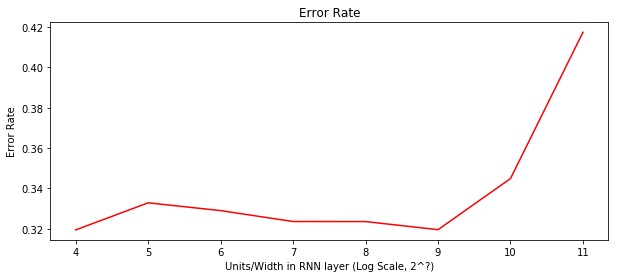

In [ ]:
#influence of widths
plt.figure(figsize=(10,4))
plt.plot([np.log(i)/np.log(2) for i in param2_space],param2,color='red')
plt.ylabel("Error Rate")
plt.xlabel("Units/Width in RNN layer (Log Scale, 2^?)")
plt.title("Error Rate")

Greater width might not increase prediction accuracy, as is the case with CNN. It is probably because our data do not have too many features for the model to capture. Hence going deeper is basically overfitting. The best RNN model is thus simple RNN with units=16. 

## 4.3 Train the Best RNN Model with More Data

As before, we train our best RNN model with exactly the same setting of section 3.7 so that comparison can be made. 

In [ ]:
#reset parameters
n_epoch = 10
units = 16

error_best_rnn = rnn(units=16, n_epoch=n_epoch,printing=False)

21977/21977 [==============================] - 1s 43us/sample - loss: 0.5968 - acc: 0.6849


In [ ]:
print("Error rate for best RNN model is",error_best_rnn)

Error rate for best RNN model is 0.31510215997695923


# 5. Naive Bayes

In [ ]:
def classify(model):
  ''''''
  
  model.fit(X_train, Y_train.astype('int'))
  predictions = model.predict(X_test)

  return np.mean(np.array(predictions)!=np.array(Y_test))

In [ ]:
bayes = classify(naive_bayes.MultinomialNB())
print("Error rate for Naive Bayes:",bayes)

Error rate for Naive Bayes: 0.34495154024662145


We can see that error rate for Naive Bayes classifier is 34.50% which is a lot higher than CNN and RNN. This means Logistic Regression and Linear Discriminant Analysis because they all have similar nature. It is thus unnecessary for us to try these two methods, but support vector machines, random forests (bagging) and boosting methods might be interesting, so are sparse methods like ridge, lasso and elastic nets. But for the purpose of this report we will not include those further. 

# 6.Conclusion

We have explored 3 different main methods for text classification on the data of politicians' tweets. After running 50 epochs, each with batch of 128 and running through all the data, here are 

* Convolutional Neural Network (CNN) has suggested the model $$CNN_{best}=[Convolutional\rightarrow Normalise]\times 1\rightarrow [Dense\rightarrow Normalise]\times 1 \\ \text{   with Tangent Hyperbolic Activation, Convolutional Filter=16, Dense Units=16}$$ with an error rate of $28.5\text{%}$.

* Recurrent Neural Network (RNN) has suggested a simple layer with $width=16$ and resulted in an error rate of $31.51\text{%}$. 

* Naive Bayes classifier ended up with an error rate of $34.50\text{%}$

It is thus concluded that for our example, CNN consisting of 1 convolutional layer and 1 dense layer, with normalisation, small filters and width has the best prediction accuracy. 

# Reference

* Understanding the Disharmony between Dropout and Batch Normalization by Variance Shift https://arxiv.org/abs/1801.05134 

* London School of Economics, Department of Statistics https://github.com/lse-st449/lectures

* Performance Analysis of Various Activation Functions in
Generalized MLP Architectures of Neural Networks http://www.cscjournals.org/manuscript/Journals/IJAE/Volume1/Issue4/IJAE-26.pdf 

* Tensorflow Keras Directory https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential

* Maron, M. E. (1961). "Automatic Indexing: An Experimental Inquiry" (PDF). Journal of the ACM. 8 (3): 404–417. doi:10.1145/321075.321084.